This notebook performs final evaluation on preserved test set and provides inference demo

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from startup_checks import ensure_project_dirs, check_required_artifacts
ensure_project_dirs()
# Tuning requires preprocessing artifacts (tokenizer and label map) and best model weights artifacts
check_required_artifacts(require_model=False)

2025-12-19 17:15:10.212641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 17:15:10.266882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All required artifacts are found. Notebook is ready


2025-12-19 17:15:11.318901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from config import TEXT_COL, LABEL_COL, CLEAN_FILE, RANDOM_STATE, MAX_LEN, MAX_LEN, VOCAB_SIZE, BEST_WEIGHT_FILE
from preprocess import load_and_clean_data, text_to_padded_sequences
from artifacts_utils import load_label_artifacts, load_tokenizer, load_best_model_metadata, save_final_metrics
from utils import reset_tf_state, encode_labels, evaluate_and_plot, show_label_distribution
from models import build_bilstm_model

from sklearn.model_selection import train_test_split

In [3]:
reset_tf_state(RANDOM_STATE)

# Load dataset 
df = load_and_clean_data(CLEAN_FILE, basic_clean=False, clean_label=False)

texts = df[TEXT_COL].values
labels = df[LABEL_COL].values

In [4]:
# Load label artifacts
label_order, label_to_id, id_to_label = load_label_artifacts()
y_encoded = encode_labels(labels, label_to_id)

In [5]:
# Split test data same as before
X_train, X_test, y_train, y_test = train_test_split(
    texts, y_encoded,
    stratify=y_encoded,
    test_size=0.15,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.15/0.85,
    random_state=RANDOM_STATE
)

In [6]:
# Load tokenizer & preprocess test data
tokenizer = load_tokenizer()

X_test_pad, _ = text_to_padded_sequences(
    tokenizer,
    X_test,
    max_len=MAX_LEN
)

In [7]:
# Load best model metadata and rebuild best model
best_model_metadata = load_best_model_metadata()

model = build_bilstm_model(
    best_model_metadata["hyperparams"],
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    classes_qty=len(label_order)
)

model.load_weights(BEST_WEIGHT_FILE)

I0000 00:00:1766135712.091635   65273 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-12-19 17:15:17.208328: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


----------------- Metrics -----------------
 test_macro_f1  test_acc  test_loss
      0.636978  0.685291   0.790471
-------------------------------------------

              precision    recall  f1-score   support

    positive       0.69      0.76      0.72       278
    negative       0.39      0.52      0.44       129
     neutral       0.81      0.69      0.74       470

    accuracy                           0.69       877
   macro avg       0.63      0.66      0.64       877
weighted avg       0.71      0.69      0.69       877



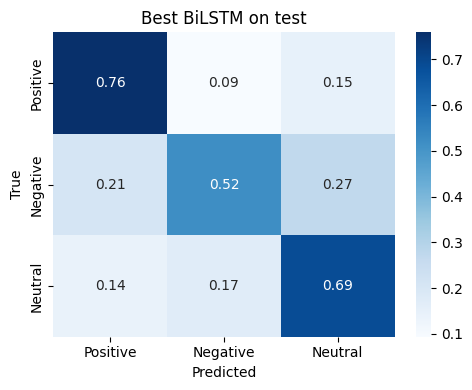

Best model: test_loss = 0.7905, test_acc = 0.6853


In [8]:
# Evaluate best model on the held out test set
test_metrics = evaluate_and_plot(model, X_test_pad, y_test, label_order, split_name="test", title="Best BiLSTM on test")

print(f"Best model: test_loss = {test_metrics['test_loss']:.4f}, test_acc = {test_metrics['test_acc']:.4f}")

In [9]:
# Save Btest metrics to artifacts/result
test_metrics["split"] = "test"
test_metrics["model"] = "BiLSTM"
test_metrics["stage"] = "04-Final Inference"

save_final_metrics(
    metrics=test_metrics,
)

Metrics are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/results/final_metrics.json


## Sanity Check

Label distribution is verified to remain the same across train, validation and test set.

In [10]:
# Show label distribution
show_label_distribution(y_train, "Train")
show_label_distribution(y_val, "Validation")
show_label_distribution(y_test, "Test")

Train label distribution (%)
2    53.57
0    31.70
1    14.73
Name: proportion, dtype: float64
Validation label distribution (%)
2    53.59
0    31.70
1    14.71
Name: proportion, dtype: float64
Test label distribution (%)
2    53.59
0    31.70
1    14.71
Name: proportion, dtype: float64


## Final Result - Test Set Evaluation

The final tuned BiLSTM model achieved **Macro F1-score** of **approximately 0.64** on the held-out test set.
It performed comparably to the untuned BiLSTM baseline **(~0.64)** and improved over the the TF-IDF + Logistic Regression **(~0.62)**.

The final evaluation metrics are saved in **artifacts/results/final_metrics.json**.
This file represents the final reproducible result of the project.